# Algorithmic trading

In [2]:
from pandas_datareader import data as pdr
import pandas as pd
import yfinance as yf
yf.pdr_override()

In [3]:
import mplfinance as mpf
import pandas_ta as ta

In [4]:
start = '2021-01-01'
end = '2022-01-01'
data = pdr.get_data_yahoo('nflx', start = start, end = end)

[*********************100%***********************]  1 of 1 completed


## MACD strategy

### manual MACD

In [44]:
def get_MACD(data, n_long = 26, n_short = 12 , n_signal = 9):
    
    EMA_long = data['Close'].ewm(span = n_long, 
                                  min_periods = (n_long+1)).mean()
    EMA_short = data['Close'].ewm(span = n_short, 
                                 min_periods = (n_short+1)).mean()
    MACD = EMA_short - EMA_long
    signal = MACD.ewm(span = n_signal,  min_periods = 9+1).mean()
    hist = MACD - signal
    
    data['MACD'] = MACD
    data['signal'] = signal
    data['histogram'] = hist
    
    return data

In [25]:
data_MACD = get_MACD(data, 26, 12, 9 )

In [27]:
data_MACD

,Open,High,Low,Close,Adj Close,Volume,MACD,signal,histogram
Date,,,,,,,,,
2020-12-31,525.530029,545.500000,523.150024,540.729980,540.729980,5392300,NaN,NaN,NaN
2021-01-04,539.000000,540.799988,515.090027,522.859985,522.859985,4444400,NaN,NaN,NaN
2021-01-05,521.549988,526.780029,515.890015,520.799988,520.799988,3133900,NaN,NaN,NaN
2021-01-06,511.970001,513.099976,499.500000,500.489990,500.489990,5346200,NaN,NaN,NaN
2021-01-07,508.279999,516.440002,506.420013,508.890015,508.890015,3686400,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2021-12-27,615.000000,615.000000,609.250000,613.119995,613.119995,2061500,-10.781432,-12.607218,1.825785
2021-12-28,614.950012,618.409973,609.690002,610.710022,610.710022,1882800,-9.895192,-12.064813,2.169621
2021-12-29,610.710022,613.979980,604.679993,610.539978,610.539978,1287200,-9.101643,-11.472179,2.370536


### ta macd

In [29]:
data_MACD_ta = data.ta.macd(fast = 12, slow = 26, signal = 9)

In [30]:
data_MACD_ta

,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9
Date,,,
2020-12-31,NaN,NaN,NaN
2021-01-04,NaN,NaN,NaN
2021-01-05,NaN,NaN,NaN
2021-01-06,NaN,NaN,NaN
2021-01-07,NaN,NaN,NaN
...,...,...,...
2021-12-27,-10.781432,1.825785,-12.607217
2021-12-28,-9.895191,2.169621,-12.064812
2021-12-29,-9.101642,2.370536,-11.472178


### buy sell signal

In [33]:
def buy_sell(df, hist_colname):
    df['shift_hist'] = df[hist_colname].shift(1)
    df.loc[ (df[hist_colname] > 0) & (df['shift_hist'] < 0), 'action'] = 'buy'
    df.loc[ (df[hist_colname] < 0) & (df['shift_hist'] > 0), 'action'] = 'sell'
    df.loc[ (df['action'] == 'buy'), 'marker_position'] = df['Low'] * 0.98
    df.loc[ (df['action'] == 'sell'), 'marker_position'] = df['High'] * 1.02
    return df

In [35]:
data_MACD_buysell = buy_sell(data_MACD,'histogram')

In [38]:
data_MACD_buysell[ (data_MACD_buysell.action == 'buy') |
                  (data_MACD_buysell.action == 'sell')
                 ]

,Open,High,Low,Close,Adj Close,Volume,MACD,signal,histogram,shift_hist,action,marker_position
Date,,,,,,,,,,,,
2021-03-17,522.000000,528.369995,514.299988,524.440002,524.440002,2817400,-6.312581,-6.458679,0.146098,-0.564388,buy,504.013988
2021-03-18,516.400024,517.900024,503.850006,504.790009,504.790009,4094500,-7.198124,-6.606927,-0.591198,0.146098,sell,528.258025
2021-03-22,509.130005,529.309998,509.130005,523.109985,523.109985,3360600,-6.309777,-6.647028,0.337251,-0.497107,buy,498.947405
2021-03-26,502.820007,508.720001,496.679993,508.049988,508.049988,3467800,-5.856311,-5.779818,-0.076493,0.328441,sell,518.894401
2021-03-29,505.660004,518.000000,504.399994,513.950012,513.950012,3330000,-5.655342,-5.754911,0.099568,-0.076493,buy,494.311994
2021-04-21,508.000000,515.460022,503.600006,508.899994,508.899994,22897400,3.343525,5.034019,-1.690494,1.312024,sell,525.769222
2021-05-20,489.549988,502.700012,488.980011,501.670013,501.670013,3721200,-8.990995,-9.618333,0.627338,-0.602271,buy,479.200411
2021-06-10,487.170013,490.209991,482.140015,487.269989,487.269989,4382900,-4.646505,-4.443946,-0.202559,0.014356,sell,500.014191
2021-06-14,489.679993,503.500000,486.910004,499.890015,499.890015,4400200,-3.772244,-4.347940,0.575696,-0.191672,buy,477.171804


### plotting

In [100]:
def plot_MACD_sig(df):
    mpf_MACD = mpf.make_addplot(df['MACD'], 
                                panel = 1, color = 'blue', 
                                title = 'MACD')
    mpf_signal = mpf.make_addplot(df['signal'], 
                                panel = 1, color = 'orange')
    
    colors = ['green' if value >= 0 else 'red' 
              for value in df['histogram'] ]
    mpf_histogram = mpf.make_addplot(df['histogram'], 
                                     panel = 1, color = colors,type = 'bar')
    
    markers = ['^' if x == 'buy' else 'v' for x in df['action']]
    color_markers = ['green' if x == 'buy' else 'red' for x in df['action']]
    plot_signal = mpf.make_addplot(df['marker_position'], type = 'scatter',
                                  markersize = 30, marker = markers,
                                  color = color_markers)
    
    #plots = [mpf_MACD, mpf_signal, mpf_histogram]
    plots = [mpf_MACD, mpf_signal, mpf_histogram, plot_signal]
    
    return plots

In [101]:
a = plot_MACD_sig(data_MACD_buysell)

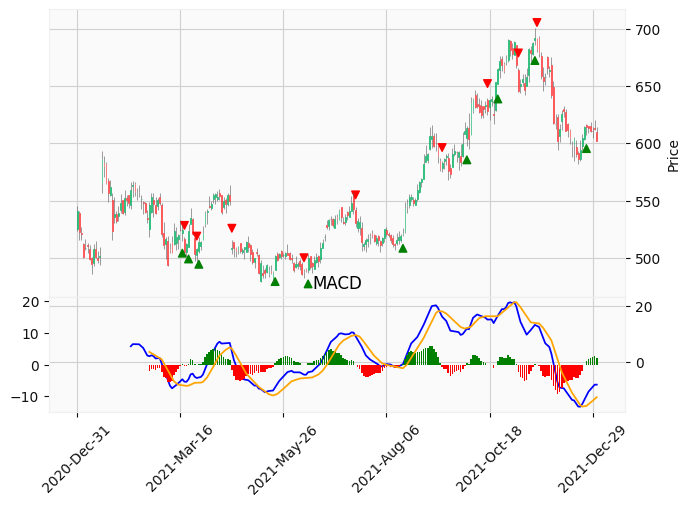

In [102]:
mpf.plot(data_MACD_buysell, type = 'candle', style = 'yahoo', addplot = a )